In [51]:
# 1 - DATA MANIPULATION
import pandas as pd
import numpy as np

# 2 - DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# 3 - DATA EXPLORATION
from ydata_profiling import ProfileReport

# 4 - FEATURE ENGINEERING AND PREPROCESSING
import string #punctuation
import textstat

import nltk #English language stopwords
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

from transformers import BertTokenizer, TFBertModel
from transformers import AutoTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.constraints import MaxNorm

import spacy
nlp = spacy.load("en_core_web_sm")

from lexicalrichness import LexicalRichness

import re

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.regularizers import l1, l2, l1_l2


# 5 - MODEL
#SKLEARN METRICS
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline



from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import models
from tensorflow.keras.utils import plot_model


In [52]:
import tensorflow as tf
print(tf.test.gpu_device_name())


/device:GPU:0


2023-12-07 18:30:06.074539: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-07 18:30:06.074560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [53]:
# Check tensorflow metal:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [54]:
# gpu is slower for this challenge
# Disable GPUs:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


In [55]:
df = pd.read_csv('/Users/andreacalcagni/code/AndreaCalcagni/neuroCraft/raw_data/CLEAR Corpus 6.01 - CLEAR Corpus 6.01.csv')


In [56]:
df = df.drop(columns=['Last Changed', 'URL', 'Anthology', 'MPAA \n#Max', 'Pub Year', 'MPAA\n#Avg', 'License', 'British Words', 'firstPlace_pred', 'secondPlace_pred', 'thirdPlace_pred',
       'fourthPlace_pred', 'fifthPlace_pred', 'sixthPlace_pred', 'ID', 'Author', 'Title', 'Source', 'Category', 'Location', 'MPAA\nMax', 'BT s.e.', 'Kaggle split'])


# 1. Feature Engineering

## 1.1 Text-Based Features

### 1.1.1. Word Count

In [57]:
def avg_word_count(row):
    return row[['Joon\nWC v1', 'Google\nWC']].mean()

# Create a new column
df['Avg Word Count'] = df.apply(avg_word_count, axis=1)
df = df.drop(columns=['Joon\nWC v1', 'Google\nWC'])


### 1.1.2 Unique Word Count

In [58]:
def count_unique_words(row):
    words = row['Excerpt'].split()
    return len(set(words))

df['Unique Word Count'] = df.apply(count_unique_words, axis=1)


### 1.1.3 Word Lenght

In [59]:
def avg_word_length(x):
    punctuation = string.punctuation
    for punc in punctuation:
        x = x.replace(punc,' ')
    words = x.split(' ')
    words = [word for word in words if len(word) > 0]
    word_len = [len(word) for word in words]
    return np.mean(word_len)

# New column 'Avg Word Length'
df['Avg Word Length'] = df['Excerpt'].apply(avg_word_length)


### 1.1.4 Sentence Count

In [60]:
def calculate_average_sentence_count(row):
    sentence_count_columns = ['Sentence\nCount v1', 'Sentence\nCount v2']
    return row[sentence_count_columns].mean()

# new column
df['Average Sentence Count'] = df.apply(calculate_average_sentence_count, axis=1)
df= df.drop(columns=['Sentence\nCount v1', 'Sentence\nCount v2'])


## 1.2 Complexity Features

### 1.2.1 Average Syllaba per Word

In [61]:
def avg_syllaba_word(x):
    syll_count = [textstat.syllable_count(word) for word in x.split()]
    return np.mean(syll_count)

df['Avg Syllables Per Word'] = df['Excerpt'].apply(avg_syllaba_word)


### 1.2.2 Avg Vowels per Word

In [62]:
def count_vowels(word):
    vowels = set("AEIOUaeiou")
    return sum(1 for char in word if char in vowels)

# New columns:
df['Avg Vowel Count Per Word'] = df['Excerpt'].apply(lambda x: np.mean([count_vowels(word) for word in x.split()]) if x else 0)
df['Total Vowels Per Excerpt'] = df['Excerpt'].apply(lambda x: sum(count_vowels(word) for word in x.split()) if x else 0)
df['Avg Vowels Per Excerpt'] = df['Total Vowels Per Excerpt']/df['Avg Word Count']
df = df.drop(columns=['Total Vowels Per Excerpt'])


### 1.2.3 Punctuation Ratio

In [63]:
def count_punctuation(x):
    punc = string.punctuation
    count=0

    for char in x:
        if char in punc:
            count+=1

    return count/ len(x)

df['punctuation_ratio'] = df['Excerpt'].apply(count_punctuation)


## 1.3 Structural Features

### 1.3.1 Average Sentence Lenght

In [64]:
def count_characters_per_sentence(excerpt):
    # Tokenize the text into sentences
    sentences = sent_tokenize(excerpt)

    # Count the number of characters in each sentence
    char_counts_per_sentence = [len(sentence) for sentence in sentences]

    return char_counts_per_sentence

df['Characters Per Sentence'] = df['Excerpt'].apply(count_characters_per_sentence)

def avg_chars_per_sentence(row):
    # Sum of character counts in all sentences
    total_chars = sum(row['Characters Per Sentence'])

    # Sum of sentence counts from both columns
    total_sentences = row['Average Sentence Count']

    # Calculate average characters per sentence
    return total_chars / total_sentences if total_sentences > 0 else 0

df['Avg Characters per Sentence'] = df.apply(avg_chars_per_sentence, axis=1)
df = df.drop(columns=['Characters Per Sentence'])


### 1.3.2 Ratio of Capital Letters

In [65]:
def ratio_capital_chars(excerpt):
    count = 0
    for char in excerpt:
        if char.isupper():
            count += 1
    return count/len(excerpt)

# new column
df['Capital Char Count'] = df['Excerpt'].apply(ratio_capital_chars)


In [66]:
def count_capital_words(excerpt):
    return sum(1 for word in excerpt.split() if word.isupper() and word.isalpha())

# new column
df['Capital Word Count'] = df['Excerpt'].apply(count_capital_words)
df['Ratio_capital_words'] = df['Capital Word Count']/df['Avg Word Count']
df = df.drop(columns=['Capital Word Count'])


## 1.4 Statistical Features

### 1.4.1 Std of Word Lenght

In [67]:
def word_length_std(excerpt):
    word_lengths = [len(word) for word in excerpt.split()]
    return np.std(word_lengths) if len(word_lengths) > 0 else 0

# New column 'Word Length Std'
df['Word Length Std'] = df['Excerpt'].apply(word_length_std)


### 1.4.2 Std of Sentence Lenght

In [68]:
def sentence_length_variation(row):
    sentence_lengths = count_characters_per_sentence(row['Excerpt'])
    return np.std(sentence_lengths)

df['Sentence Length Variation'] = df.apply(sentence_length_variation, axis=1)


## 1.5 Syntactic Complexity Features (NLP approach)

### 1.5.1 Avg sentence len in words

In [69]:
def sentence_len(x):

    x = x.replace("?",'.').replace("!",'.')

    sentences = x.split('.')

    sentences = [sentence for sentence in sentences if len(sentence) > 0]

    sent_len = [len(sentence.split()) for sentence in sentences]

    return np.mean(sent_len)

df['avg_sentence_len_words'] = df['Excerpt'].apply(sentence_len)


### 1.5.2 Number of clauses per sentence

In [70]:
# Function to calculate the number of clauses per sentence

# # Function to perform POS tagging and count occurrences of each POS
# def pos_distribution(excerpt):
#     # Parse the text using spaCy
#     doc = nlp(excerpt)
#     # Count the occurrences of each POS
#     pos_counts = Counter(token.pos_ for token in doc)
#     return pos_counts


# # Apply functions to create new columns
# df['Num Clauses Per Sentence'] = df['Excerpt'].apply(num_clauses_per_sentence_nlp)

# df['POS Distribution'] = df['Excerpt'].apply(pos_distribution)


In [71]:
# Function to calculate the number of clauses per sentence
# def num_clauses_per_sentence_nlp(excerpt):
#     # Parse the text using spaCy
#     doc = nlp(excerpt)
#     # Count the number of clauses (sentences) in the parsed document
#     num_clauses = len(list(doc.sents))
#     return num_clauses

# df['Num Clauses Per Sentence'] = df['Excerpt'].apply(num_clauses_per_sentence_nlp)


## 1.6 Lexical Diversity

In [72]:
def add_lexical_richness_features(df):
    cttr_list, msttr_list, mtld_list, yule_k_list = [], [], [], []

    for text in df['Excerpt']:
        lex = LexicalRichness(text)
        cttr_list.append(lex.cttr)
        msttr_list.append(lex.msttr(segment_window=25))  # Adjust the segment_window as needed
        mtld_list.append(lex.mtld(threshold=0.72))  # Adjust the threshold as needed
        yule_k_list.append(lex.yulek)

    df['cttr'] = cttr_list
    df['msttr'] = msttr_list
    df['mtld'] = mtld_list
    df['yule_k'] = yule_k_list

# Add lexical richness features to the DataFrame
add_lexical_richness_features(df)


In [73]:
# lexical_columns = ['cttr', 'msttr', 'mtld', 'yule_k']

# # new DataFrame with only the selected columns
# lexical_df = df[lexical_columns]

# # Calculate the correlation matrix
# correlation_matrix = lexical_df.corr()

# # Plot a heatmap of the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title("Correlation Matrix of Lexical Richness Features")
# plt.show()


# 2. Discretizing Target

In [74]:
# Calculating quantiles for bin edges - 7 edges for 6 bins
# quantiles = df['BT Easiness'].quantile([0, 0.1667, 0.3333, 0.5, 0.6667, 0.8333, 1]).tolist()

quantiles = df['BT Easiness'].quantile([0, 0.3333, 0.6667, 1]).tolist()


In [75]:
# Correct number of labels for 6 bins
labels_dict = {'hard':0, 'acceptable':1, 'easy':2}

# Using 'quantiles' for bins and including 6 labels
df['BT Easiness'] = pd.cut(
    x=df['BT Easiness'],
    bins=quantiles,
    labels=labels_dict.values(),
    include_lowest=True
)


# 3. Train Test Split

In [76]:
X = df.drop(columns=['BT Easiness'])
y = df['BT Easiness']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 4. Dummy Baseline Model

In [77]:
y_pred = y_train.value_counts().idxmax()
y_pred = np.full(y_test.shape, y_pred)

accuracy_baseline = accuracy_score(y_test, y_pred)
accuracy_baseline


0.3164021164021164

# 5. NLP Model

## 5.1 Text Preprocessing

In [78]:
X_train_text = X_train['Excerpt'].values
X_test_text = X_test['Excerpt'].values


### 5.1.1 Basic Cleaning

In [79]:
def basic_cleaning(sentence):
    sentence = sentence.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())

    # Adding special quotes to the regular expression pattern
    special_quotes = '“”‘’'
    pattern = '[' + re.escape(string.punctuation + special_quotes) + ']'

    sentence = re.sub(pattern, '', sentence)
    sentence = sentence.strip()

    return sentence


In [80]:
X_train_text = [basic_cleaning(sentence) for sentence in X_train_text]
X_test_text = [basic_cleaning(sentence) for sentence in X_test_text]


### 5.1.2 Tokenizing

In [81]:
# def tokenizer(sentence):
#     return text_to_word_sequence(sentence)


In [82]:
# #tokenizing
# X_train_text = [tokenizer(sentence) for sentence in X_train_text]
# X_test_text = [tokenizer(sentence) for sentence in X_test_text]


### 5.1.3 Lemmatizing

In [83]:
# def lemmatizer(sentence):
#     wnl = WordNetLemmatizer()
#     verbs_lemmatized = []
#     for word in sentence:
#         verbs_lemmatized.append(wnl.lemmatize(word, pos = 'v'))
#     nouns_lemmatized = []
#     for word in verbs_lemmatized:
#         nouns_lemmatized.append(wnl.lemmatize(word, pos = 'n'))
#     adverbs_lemmatized = []
#     for word in nouns_lemmatized:
#         adverbs_lemmatized.append(wnl.lemmatize(word, pos = 'r'))
#     adj_lemmatized = []
#     for word in adverbs_lemmatized:
#         adj_lemmatized.append(wnl.lemmatize(word, pos = 'a'))
#     sat_lemmatized = []
#     for word in adj_lemmatized:
#         sat_lemmatized.append(wnl.lemmatize(word, pos = 'a'))
#     return sat_lemmatized


In [84]:
# X_train_text = [lemmatizer(sentence) for sentence in X_train_text]
# X_test_text = [lemmatizer(sentence) for sentence in X_test_text]


### 5.1.4 Removing Stopwords

In [85]:
# def removing_stopwords(sentence):
#     stop_words = set(stopwords.words('english'))
#     sentence_new = [w for w in sentence if not w in stop_words]
#     return sentence_new

# X_train_text = [removing_stopwords(sentence) for sentence in X_train_text]
# X_test_text = [removing_stopwords(sentence) for sentence in X_test_text]


### 5.1.5 Creating Embeddings

In [86]:
def create_embeddings(excerpts, model_name="roberta-base", max_length=190):
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="right")
    model = TFAutoModel.from_pretrained(model_name, from_pt=True)

    # Tokenize all excerpts at once
    tokenized_excerpts = tokenizer(excerpts, max_length=max_length, padding="max_length", truncation=True, return_tensors="tf")

    # Generate embeddings in a batch
    embeddings = model.predict(tokenized_excerpts["input_ids"])

    return embeddings.last_hidden_state#[:,0,:]

# Assuming X_train_text and X_test_text are lists of sentences/excerpts
with tf.device('/GPU:0'):  # Change to '/CPU:0' if you want to use CPU
    X_train_text = create_embeddings(X_train_text)
    X_test_text = create_embeddings(X_test_text)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

119/119 [==============================] - 47s 395ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

30/30 [==============================] - 12s 396ms/step


In [87]:
X_train_text.shape


(3779, 190, 512)

## 5.2 Model Training

In [88]:
# def build_model_nlp():
#     model = Sequential([
#         # layers.Conv1D(105, kernel_size=15, padding='same', activation="relu", input_shape=X_train_pad.shape[1:]),
#         # layers.Conv1D(64, kernel_size=10, padding='same', activation="relu"),
#         # layers.Flatten(),
#         #layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=X_train_text.shape[1:]),
#         #layers.Bidirectional(layers.LSTM(64), input_shape=(512,)),
#         #layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(512,)),
#         layers.Bidirectional(layers.LSTM(64, kernel_constraint=MaxNorm(3)), input_shape=X_train_text.shape[1:]),
#         layers.Dropout(0.3),
#         layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
#         layers.Dropout(0.3),
#         layers.Dense(4, activation='softmax'),
#     ])

#     model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
#     return model

# model_nlp = build_model_nlp()
# model_nlp.summary()


In [89]:
# es = EarlyStopping(patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# model_nlp = build_model_nlp()
# with tf.device('GPU:0'):
#     model_nlp.fit(X_train_text, y_train,
#             validation_split=0.3,
#             epochs=50,
#             batch_size=32,
#             callbacks=[es, reduce_lr]
#             )


In [101]:
def build_model_nlp():
    model = Sequential([
        layers.Bidirectional(layers.LSTM(32, kernel_constraint=MaxNorm(3), return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=X_train_text.shape[1:]),
        layers.Dropout(0.5),
        layers.Bidirectional(LSTM(16, kernel_regularizer=l2(0.01))),
        layers.Dropout(0.4),
        layers.Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.01)),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])

    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# Custom learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Callbacks
es = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
lr_scheduler = LearningRateScheduler(scheduler)

# Assuming X_train_text.shape[1:] gives (190, 512)
model_nlp = build_model_nlp()
model_nlp.summary()

# Fit the model (assuming X_train_text, y_train are defined)
with tf.device('GPU:0'):
    history = model_nlp.fit(
        X_train_text, y_train,
        validation_split=0.3,
        epochs=50,
        batch_size=32,
        callbacks=[es, reduce_lr, lr_scheduler]
    )


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 190, 64)           139520    
 onal)                                                           
                                                                 
 dropout_79 (Dropout)        (None, 190, 64)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_80 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dropout_81 (Dropout)        (None, 16)               

## 5.3 Model Evaluation

In [102]:
loss, accuracy = model_nlp.evaluate(X_test_text, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


30/30 [==============================] - 1s 29ms/step - loss: 0.7978 - accuracy: 0.7058
Test loss: 0.7978
Test accuracy: 0.7058


In [103]:
predictions = model_nlp.predict(X_test_text)

# Convert probabilities to class labels
class_labels_predictions = np.argmax(predictions, axis=1)


30/30 [==============================] - 1s 28ms/step


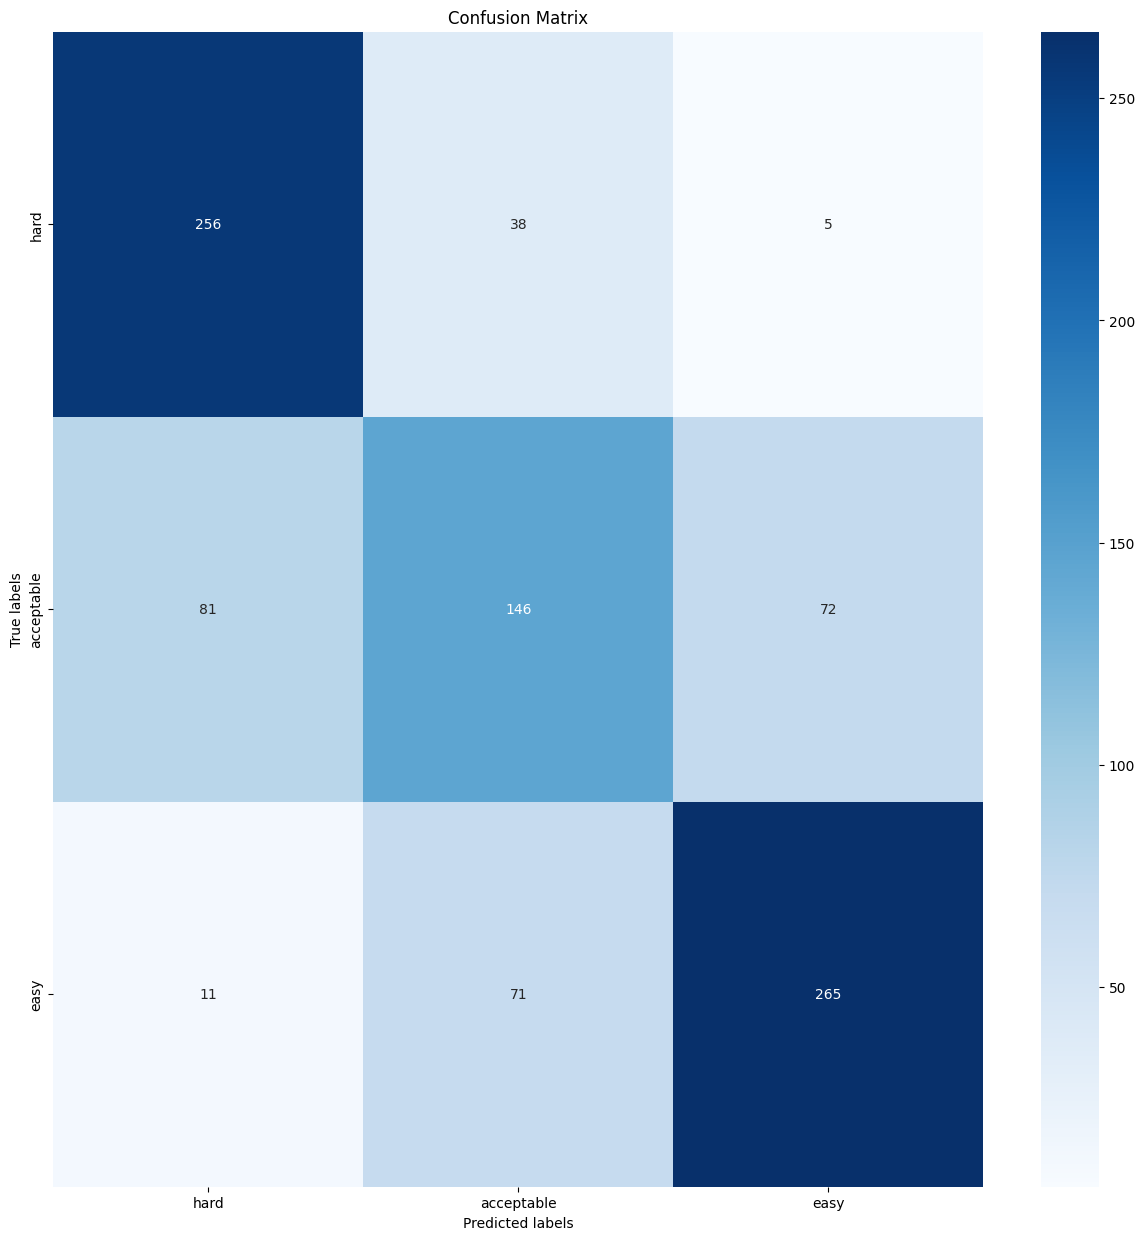

In [104]:
y_true = y_test
y_pred = class_labels_predictions

cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
ax.yaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
plt.show()


# 6. Model with numerical features

In [105]:
X_train_num = X_train.drop(columns=['Excerpt'])
X_test_num = X_test.drop(columns=['Excerpt'])


## 6.1 Preprocessing

### 6.1.1 Scaling

In [106]:
scaler = StandardScaler()
scaler.fit(X_train_num)
X_train_num = scaler.transform(X_train_num)
X_test_num = scaler.transform(X_test_num)


## 6.2 Model Training

In [107]:
def build_model_num():
    model = Sequential([
        layers.Dense(356, activation="relu", input_dim = X_train_num.shape[1]),
        layers.Dropout(0.25),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.25),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.25),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.15),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
    return model

model_num = build_model_num()
model_num.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 356)               10680     
                                                                 
 dropout_82 (Dropout)        (None, 356)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               45696     
                                                                 
 dropout_83 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_84 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)               

In [108]:
es = EarlyStopping(patience=10, restore_best_weights=True)
model_num = build_model_num()
model_num.fit(X_train_num, y_train,
          validation_split=0.3,
          epochs=50,
          batch_size=32,
          callbacks=[es]
          )


Epoch 1/50
83/83 [==============================] - 0s 2ms/step - loss: 0.9963 - accuracy: 0.5285 - val_loss: 0.8386 - val_accuracy: 0.5988
Epoch 2/50
83/83 [==============================] - 0s 2ms/step - loss: 0.8919 - accuracy: 0.5735 - val_loss: 0.8088 - val_accuracy: 0.6014
Epoch 3/50
83/83 [==============================] - 0s 2ms/step - loss: 0.8585 - accuracy: 0.5913 - val_loss: 0.8170 - val_accuracy: 0.6023
Epoch 4/50
83/83 [==============================] - 0s 2ms/step - loss: 0.8419 - accuracy: 0.6023 - val_loss: 0.8056 - val_accuracy: 0.6164
Epoch 5/50
83/83 [==============================] - 0s 2ms/step - loss: 0.8186 - accuracy: 0.6110 - val_loss: 0.7970 - val_accuracy: 0.6041
Epoch 6/50
83/83 [==============================] - 0s 2ms/step - loss: 0.8170 - accuracy: 0.6121 - val_loss: 0.8061 - val_accuracy: 0.6190
Epoch 7/50
83/83 [==============================] - 0s 2ms/step - loss: 0.8055 - accuracy: 0.6136 - val_loss: 0.8056 - val_accuracy: 0.6155
Epoch 8/50
83/83 [==

## 6.3 Model Evaluation

In [109]:
loss, accuracy = model_num.evaluate(X_test_num, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


30/30 [==============================] - 0s 481us/step - loss: 0.7664 - accuracy: 0.6349
Test loss: 0.7664
Test accuracy: 0.6349


30/30 [==============================] - 0s 485us/step


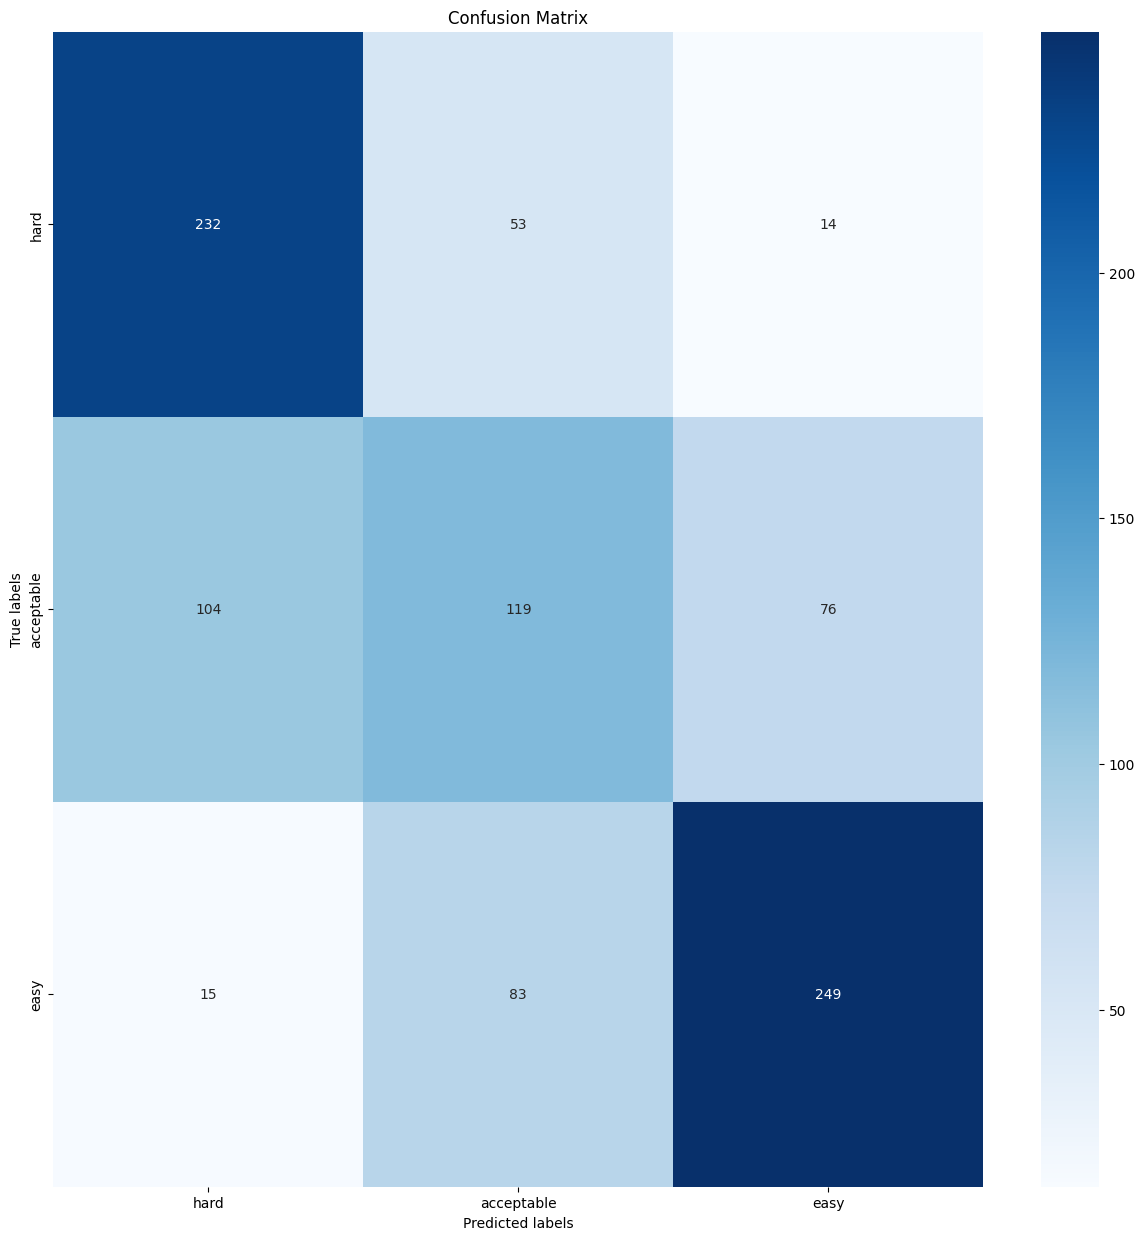

In [110]:
predictions = model_num.predict(X_test_num)

# Convert probabilities to class labels
class_labels_predictions = np.argmax(predictions, axis=1)

y_true = y_test
y_pred = class_labels_predictions

cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
ax.yaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
plt.show()


# 7. Combining the models

In [111]:
# Define Inputs and Outputs of NLP model as with Numeric Model
model_nlp = build_model_nlp() # comment-out to keep pre-trained weights not to start from scratch
input_text = model_nlp.input
output_text = model_nlp.output

model_num = build_model_num() # comment-out to keep pre-trained weights not to start from scratch
input_num = model_num.input
output_num = model_num.output


In [112]:
# Let's combine the two streams of data and add two dense layers on top!
inputs = [input_text, input_num]

combined = layers.concatenate([output_text, output_num])

x = layers.Dense(32, activation="relu")(combined)
x = layers.Dropout(0.25)(x)
x = layers.Dense(16, activation="relu")(x)

outputs = layers.Dense(3, activation="softmax")(x)

model_combined = models.Model(inputs=inputs, outputs=outputs)


In [113]:
model_combined.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
es = EarlyStopping(patience=10, restore_best_weights=True)

model_combined.fit(x=[X_train_text, X_train_num],
                   y=y_train,
                   validation_split=0.3,
                   epochs=100,
                   batch_size=32,
                   callbacks=[es])


Epoch 1/100
83/83 [==============================] - 11s 99ms/step - loss: 3.4909 - accuracy: 0.4578 - val_loss: 1.6308 - val_accuracy: 0.5697
Epoch 2/100
83/83 [==============================] - 8s 92ms/step - loss: 1.2950 - accuracy: 0.5543 - val_loss: 1.0460 - val_accuracy: 0.5758
Epoch 3/100
83/83 [==============================] - 8s 93ms/step - loss: 1.0064 - accuracy: 0.5637 - val_loss: 0.8934 - val_accuracy: 0.5996
Epoch 4/100
83/83 [==============================] - 8s 91ms/step - loss: 0.9188 - accuracy: 0.5951 - val_loss: 0.8493 - val_accuracy: 0.6129
Epoch 5/100
83/83 [==============================] - 8s 92ms/step - loss: 0.8797 - accuracy: 0.5977 - val_loss: 0.8315 - val_accuracy: 0.6235
Epoch 6/100
83/83 [==============================] - 8s 93ms/step - loss: 0.8331 - accuracy: 0.6295 - val_loss: 0.7712 - val_accuracy: 0.6499
Epoch 7/100
83/83 [==============================] - 8s 94ms/step - loss: 0.8377 - accuracy: 0.6333 - val_loss: 0.8681 - val_accuracy: 0.6349
Epoch

In [114]:
loss, accuracy = model_combined.evaluate([X_test_text, X_test_num], y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


30/30 [==============================] - 1s 30ms/step - loss: 0.7401 - accuracy: 0.6825
Test loss: 0.7401
Test accuracy: 0.6825


In [115]:
predictions = model_combined.predict([X_test_text, X_test_num])

# Convert probabilities to class labels
class_labels_predictions = np.argmax(predictions, axis=1)


30/30 [==============================] - 1s 29ms/step


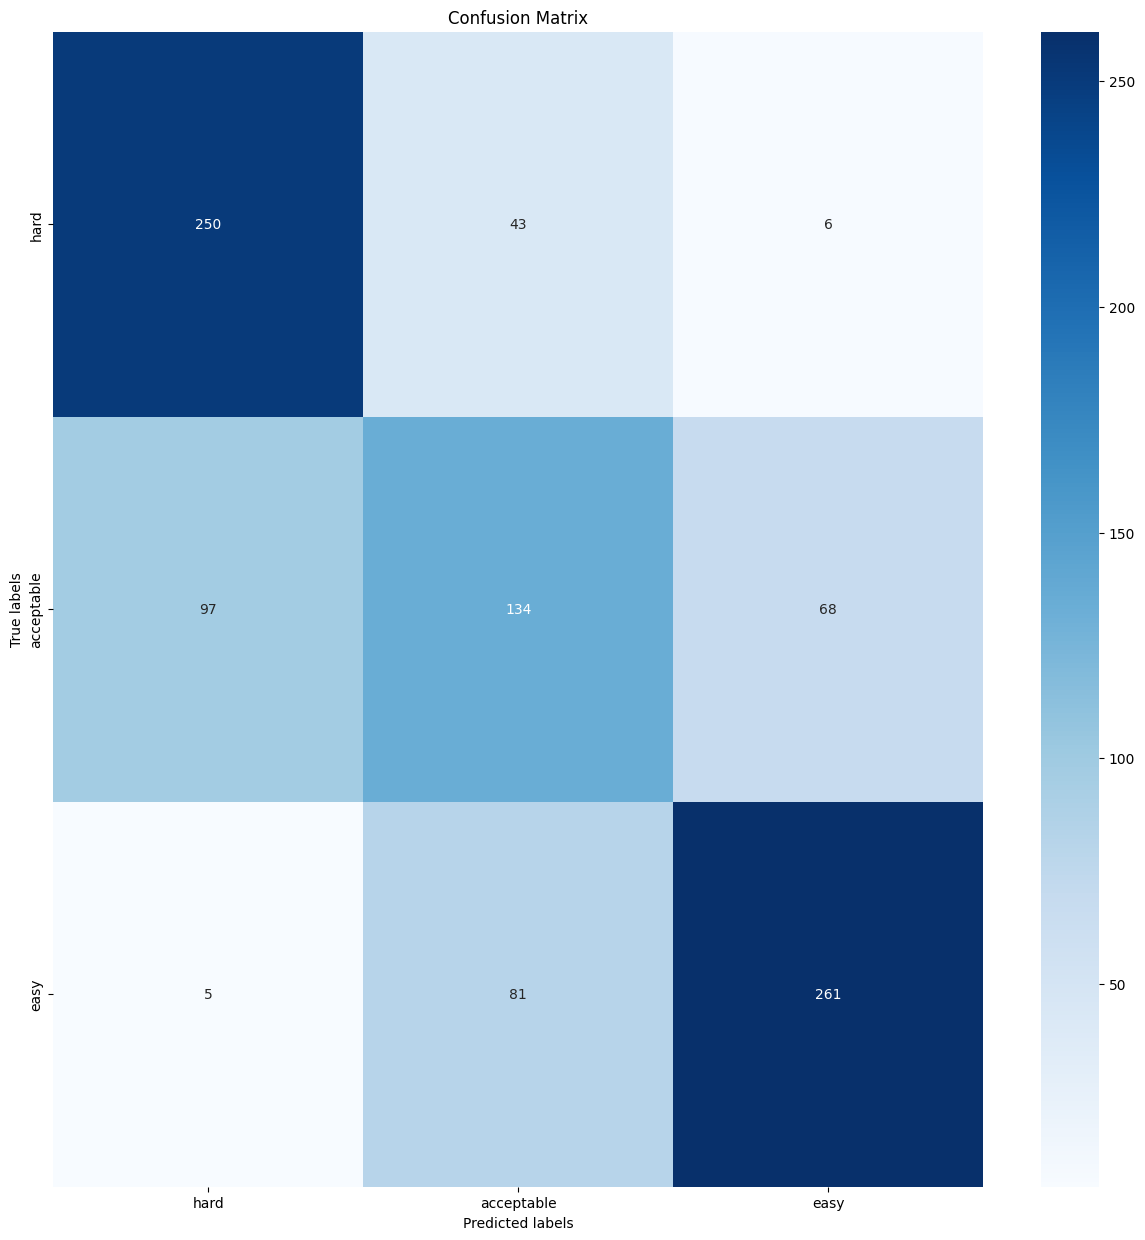

In [116]:
y_true = y_test
y_pred = class_labels_predictions

cm = confusion_matrix(y_true, y_pred)

# Plotting
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
ax.yaxis.set_ticklabels(labels_dict.keys()) # replace with your class names
plt.show()


In [ ]:
df.columns


Index(['Excerpt', 'British WC', 'Paragraphs', 'BT Easiness',
       'Flesch-Reading-Ease', 'Flesch-Kincaid-Grade-Level',
       'Automated Readability Index', 'SMOG Readability',
       'New Dale-Chall Readability Formula', 'CAREC', 'CAREC_M', 'CARES',
       'CML2RI', 'Avg Word Count', 'Unique Word Count', 'Avg Word Length',
       'Average Sentence Count', 'Avg Syllables Per Word',
       'Avg Vowel Count Per Word', 'Avg Vowels Per Excerpt',
       'punctuation_ratio', 'Avg Characters per Sentence',
       'Capital Char Count', 'Ratio_capital_words', 'Word Length Std',
       'Sentence Length Variation', 'avg_sentence_len_words', 'cttr', 'msttr',
       'mtld', 'yule_k'],
      dtype='object')

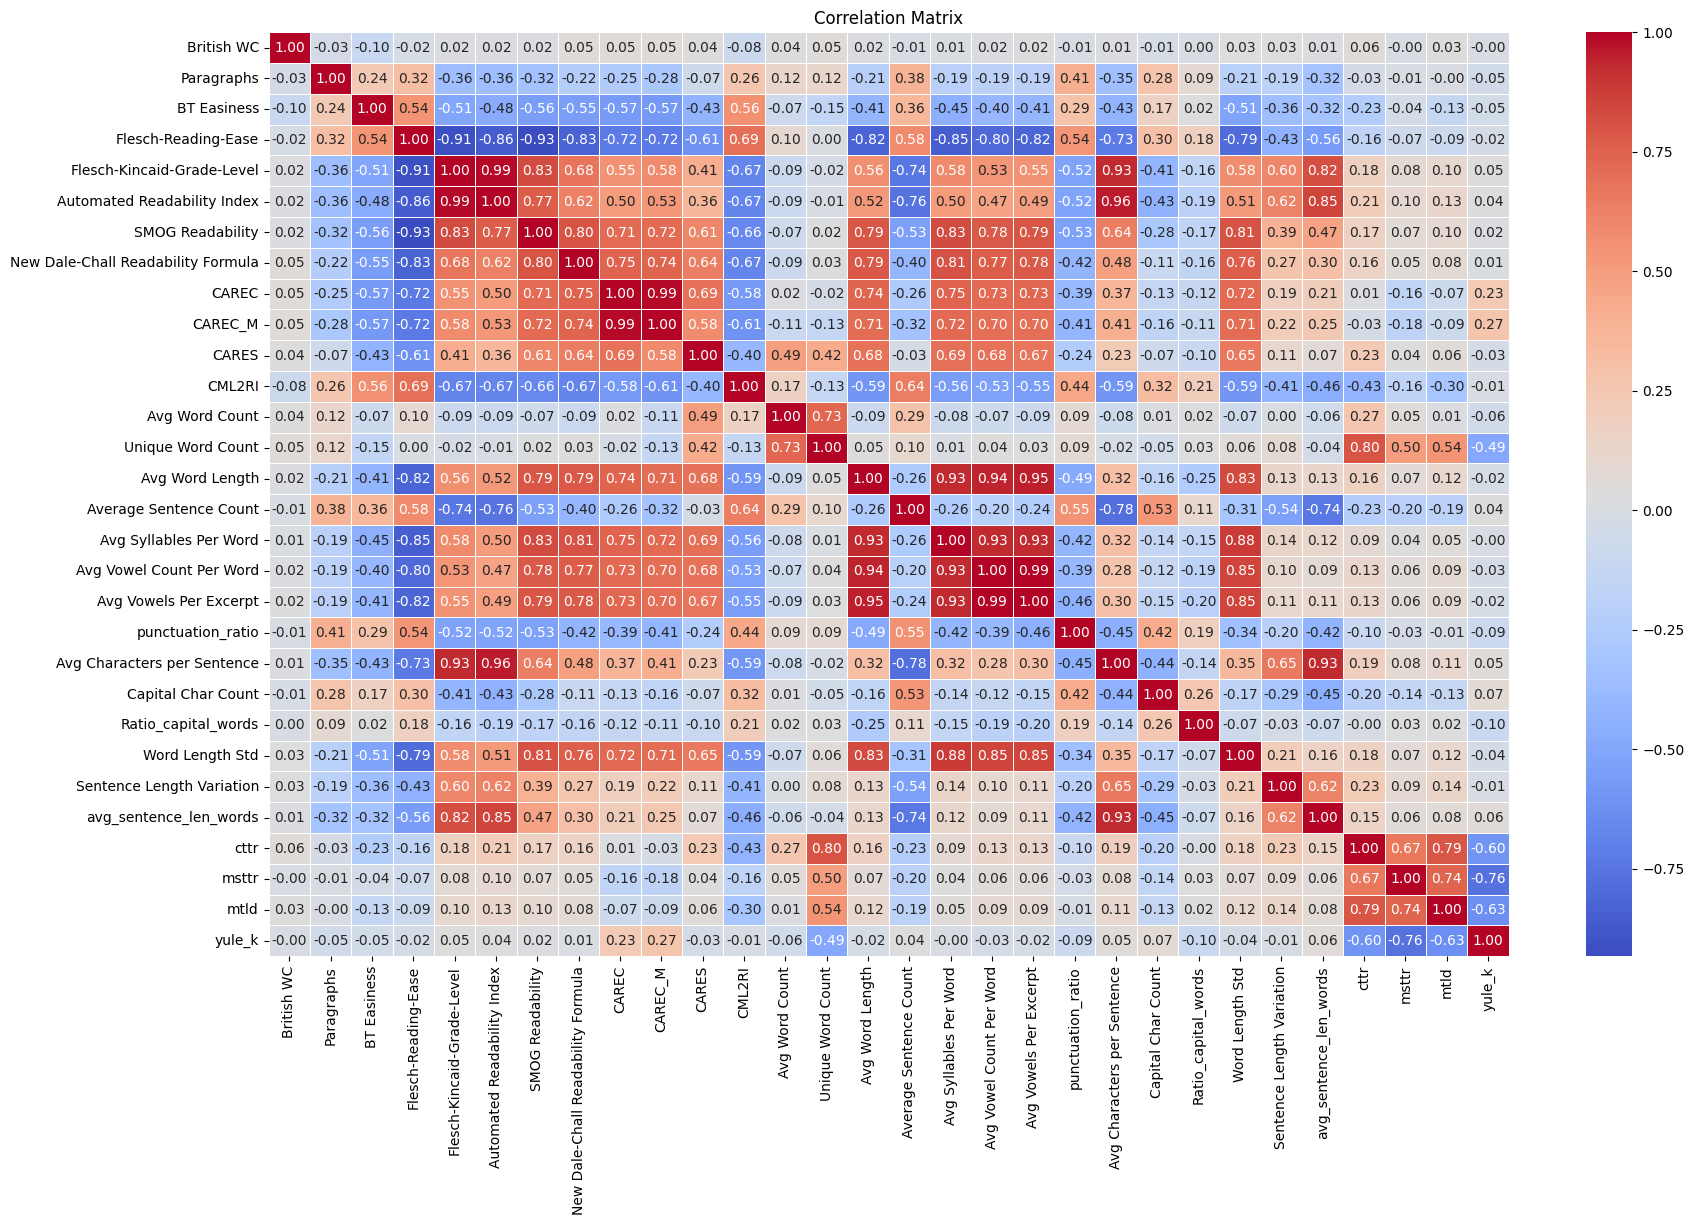

In [ ]:
df_columns = df.columns
df_num = df.drop(columns=["Excerpt"])

# Calculate the correlation matrix
correlation_matrix = df_num.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()
